In [1]:
import pandas as pd


In [2]:
website_sessions = pd.read_csv("website_sessions.csv")
orders = pd.read_csv("orders.csv")
order_items = pd.read_csv("order_items.csv")
order_item_refunds = pd.read_csv("order_item_refunds.csv")
website_pageviews = pd.read_csv("website_pageviews.csv")
products = pd.read_csv("products.csv")

In [3]:
website_sessions["created_at"] = pd.to_datetime(website_sessions["created_at"])
orders["created_at"] = pd.to_datetime(orders["created_at"])
website_pageviews["created_at"] = pd.to_datetime(website_pageviews["created_at"])


#### Aggregate orders to SESSION level

In [4]:
orders_per_session = (
    orders
    .groupby("website_session_id")
    .agg(
        orders=("order_id", "nunique"),
        revenue=("price_usd", "sum")
    )
    .reset_index()
)

orders_per_session.head()


,website_session_id,orders,revenue
0,20,1,49.99
1,104,1,49.99
2,147,1,49.99
3,160,1,49.99
4,177,1,49.99


##### Aggregate pageviews to SESSION level

In [5]:
pageviews_per_session = (
    website_pageviews
    .groupby("website_session_id")
    .size()
    .reset_index(name="pageviews")
)

pageviews_per_session.head()


,website_session_id,pageviews
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1


In [6]:
session_level = (
    website_sessions
    .merge(orders_per_session, on="website_session_id", how="left")
    .merge(pageviews_per_session, on="website_session_id", how="left")
)

session_level[["orders", "revenue", "pageviews"]] = (
    session_level[["orders", "revenue", "pageviews"]].fillna(0)
)

session_level.head()


,website_session_id,created_at,user_id,is_repeat_session,utm_source,utm_campaign,utm_content,device_type,http_referer,orders,revenue,pageviews
0,1,2012-03-19 08:04:16,1,0,gsearch,nonbrand,g_ad_1,mobile,https://www.gsearch.com,0.0,0.0,1
1,2,2012-03-19 08:16:49,2,0,gsearch,nonbrand,g_ad_1,desktop,https://www.gsearch.com,0.0,0.0,1
2,3,2012-03-19 08:26:55,3,0,gsearch,nonbrand,g_ad_1,desktop,https://www.gsearch.com,0.0,0.0,1
3,4,2012-03-19 08:37:33,4,0,gsearch,nonbrand,g_ad_1,desktop,https://www.gsearch.com,0.0,0.0,1
4,5,2012-03-19 09:00:55,5,0,gsearch,nonbrand,g_ad_1,mobile,https://www.gsearch.com,0.0,0.0,1


#### Insight:
Created a session-level dataset where each row represents one website session.

In [7]:
session_level["is_bounce"] = session_level["pageviews"] == 1


#### Insight:
Marked sessions with only one pageview as bounced sessions.

In [8]:
conversion_rate = (session_level["orders"] > 0).mean()
total_revenue = session_level["revenue"].sum()
avg_order_value = total_revenue / session_level["orders"].sum()
bounce_rate = session_level["is_bounce"].mean()

conversion_rate, total_revenue, avg_order_value, bounce_rate


(np.float64(0.0683336470200118),
 np.float64(1938509.7499999993),
 np.float64(59.99163649305231),
 np.float64(0.4475639233533035))

In [9]:
print(f"Conversion Rate: {conversion_rate:.2%}")
print(f"Total Revenue: ${total_revenue:,.2f}")
print(f"Average Order Value: ${avg_order_value:.2f}")
print(f"Bounce Rate: {bounce_rate:.2%}")


Conversion Rate: 6.83%
Total Revenue: $1,938,509.75
Average Order Value: $59.99
Bounce Rate: 44.76%


In [10]:
channel_summary = (
    session_level
    .groupby(["utm_source","utm_campaign","device_type","utm_content"])
    .agg(
        sessions=("website_session_id", "count"),
        orders=("orders", "sum"),
        revenue=("revenue", "sum"),
        bounce_rate=("is_bounce", "mean")
    )
    .reset_index()
)

channel_summary["conversion_rate"] = (
    channel_summary["orders"] / channel_summary["sessions"]
)

channel_summary["revenue_per_session"] = (
    channel_summary["revenue"] / channel_summary["sessions"]
)

channel_summary


,utm_source,utm_campaign,device_type,utm_content,sessions,orders,revenue,bounce_rate,conversion_rate,revenue_per_session
0,bsearch,brand,desktop,b_ad_2,6867,677.0,41645.31,0.332605,0.098587,6.064557
1,bsearch,brand,mobile,b_ad_2,1047,24.0,1463.71,0.524355,0.022923,1.398004
2,bsearch,nonbrand,desktop,b_ad_1,47395,3584.0,211434.40,0.476147,0.075620,4.461112
3,bsearch,nonbrand,mobile,b_ad_1,7514,234.0,14129.08,0.589034,0.031142,1.880367
4,gsearch,brand,desktop,g_ad_2,19922,2100.0,126801.76,0.325218,0.105411,6.364911
5,gsearch,brand,mobile,g_ad_2,13407,411.0,24928.92,0.515477,0.030656,1.859396
6,gsearch,nonbrand,desktop,g_ad_1,195155,16037.0,956016.90,0.421352,0.082176,4.898757
7,gsearch,nonbrand,mobile,g_ad_1,87551,2785.0,168397.31,0.510034,0.031810,1.923420
8,socialbook,desktop_targeted,desktop,social_ad_2,5590,288.0,18516.10,0.690340,0.051521,3.312361
9,socialbook,pilot,desktop,social_ad_1,522,17.0,1157.76,0.699234,0.032567,2.217931


### Time-Based Trends (Month-wise & Year-wise)


In [11]:
session_level["month"] = session_level["created_at"].dt.to_period("M")
session_level["year"] = session_level["created_at"].dt.year


In [12]:
monthly_trend = (
    session_level
    .groupby("month")
    .agg(
        sessions=("website_session_id", "count"),
        orders=("orders", "sum"),
        revenue=("revenue", "sum")
    )
    .reset_index()
)

monthly_trend


,month,sessions,orders,revenue
0,2012-03,1879,60.0,2999.40
1,2012-04,3734,99.0,4949.01
2,2012-05,3736,108.0,5398.92
3,2012-06,3963,140.0,6998.60
4,2012-07,4249,169.0,8448.31
5,2012-08,6097,228.0,11397.72
6,2012-09,6546,287.0,14347.13
7,2012-10,8183,371.0,18546.29
8,2012-11,14011,618.0,30893.82
9,2012-12,10072,506.0,25294.94


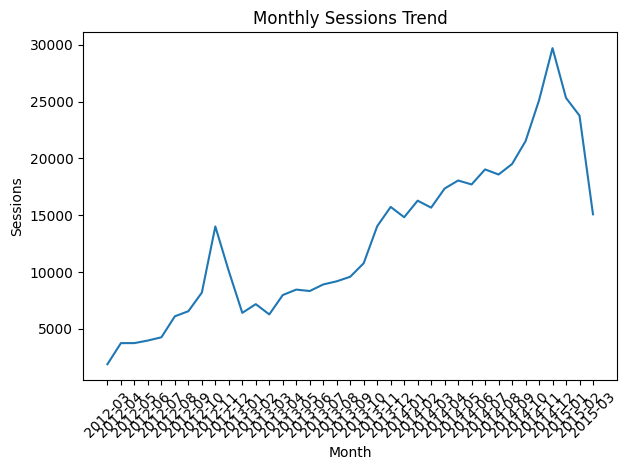

In [13]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(monthly_trend["month"].astype(str), monthly_trend["sessions"])
plt.xticks(rotation=45)
plt.title("Monthly Sessions Trend")
plt.xlabel("Month")
plt.ylabel("Sessions")
plt.tight_layout()
plt.show()


In [14]:
yearly_trend = (
    session_level
    .groupby("year")
    .agg(
        sessions=("website_session_id", "count"),
        orders=("orders", "sum"),
        revenue=("revenue", "sum")
    )
    .reset_index()
)

yearly_trend


,year,sessions,orders,revenue
0,2012,62470,2586.0,129274.14
1,2013,112781,7447.0,393247.87
2,2014,233422,16860.0,1075612.19
3,2015,64198,5420.0,340375.55


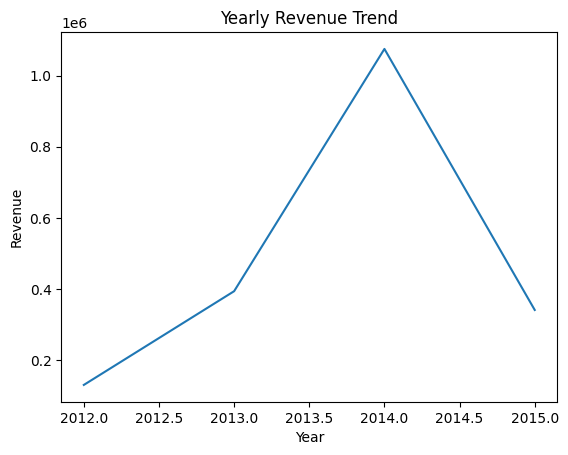

In [15]:
plt.figure()
plt.plot(yearly_trend["year"], yearly_trend["revenue"])
plt.title("Yearly Revenue Trend")
plt.xlabel("Year")
plt.ylabel("Revenue")
plt.show()


In [16]:
len(orders), len(orders_per_session)


(32313, 32313)

In [17]:
len(website_pageviews), len(pageviews_per_session)


(1188124, 472871)

In [18]:
session_level["website_session_id"].is_unique


True

## Advanced Visualizations

In [19]:
import plotly.express as px
import plotly.graph_objects as go


In [20]:
fig = px.bar(
    channel_summary,
    x="utm_source",
    y=["sessions", "orders"],
    barmode="group",
    title="Traffic vs Orders by Marketing Channel"
)

fig.show()


In [21]:
fig = px.bar(
    channel_summary,
    x="utm_source",
    y="conversion_rate",
    text_auto=".2%",
    title="Conversion Rate by Marketing Channel"
)

fig.update_yaxes(tickformat=".0%")
fig.show()


In [22]:
fig = px.bar(
    channel_summary,
    x="utm_source",
    y="revenue_per_session",
    text_auto=".2f",
    title="Revenue per Session by Marketing Channel"
)

fig.show()


In [23]:
fig = px.scatter(
    channel_summary,
    x="sessions",
    y="conversion_rate",
    size="revenue",
    color="utm_source",
    title="Traffic vs Conversion Rate by Channel",
    labels={
        "sessions": "Total Sessions",
        "conversion_rate": "Conversion Rate"
    }
)

fig.update_yaxes(tickformat=".0%")
fig.show()


In [24]:
fig = px.scatter(
    channel_summary,
    x="bounce_rate",
    y="conversion_rate",
    size="sessions",
    color="utm_source",
    title="Bounce Rate vs Conversion Rate by Channel",
    labels={
        "bounce_rate": "Bounce Rate",
        "conversion_rate": "Conversion Rate"
    }
)

fig.update_xaxes(tickformat=".0%")
fig.update_yaxes(tickformat=".0%")
fig.show()


In [25]:
monthly_trend["month"] = monthly_trend["month"].dt.to_timestamp()


In [26]:
fig = px.line(
    monthly_trend,
    x="month",
    y="sessions",
    title="Monthly Sessions Trend"
)

fig.show()


In [27]:
fig = px.line(
    monthly_trend,
    x="month",
    y="revenue",
    title="Monthly Revenue Trend"
)

fig.show()


In [28]:
session_level["month"] = session_level["month"].dt.to_timestamp()


In [29]:
monthly_channel = (
    session_level
    .groupby(["month", "utm_source"])
    .agg(sessions=("website_session_id", "count"))
    .reset_index()
)


In [30]:
fig = px.line(
    monthly_channel,
    x="month",
    y="sessions",
    color="utm_source",
    title="Monthly Sessions Trend by Channel"
)

fig.show()


In [31]:
device_channel = (
    session_level
    .groupby(["utm_source", "device_type"])
    .agg(
        sessions=("website_session_id", "count"),
        orders=("orders", "sum")
    )
    .reset_index()
)

device_channel["conversion_rate"] = (
    device_channel["orders"] / device_channel["sessions"]
)


In [32]:
fig = px.bar(
    device_channel,
    x="utm_source",
    y="conversion_rate",
    color="device_type",
    barmode="group",
    title="Conversion Rate by Channel and Device"
)

fig.update_yaxes(tickformat=".0%")
fig.show()


In [33]:
fig = px.pie(
    channel_summary,
    names="utm_source",
    values="revenue",
    hole=0.4,
    title="Revenue Contribution by Marketing Channel"
)

fig.show()


# Final Visualization

## 4 KPIs

In [34]:
total_sessions = session_level["website_session_id"].count()
bounce_rate = session_level["is_bounce"].mean()
conversion_rate = (session_level["orders"] > 0).mean()
avg_revenue_per_session = session_level["revenue"].mean()

total_sessions, bounce_rate, conversion_rate, avg_revenue_per_session


(np.int64(472871),
 np.float64(0.4475639233533035),
 np.float64(0.0683336470200118),
 np.float64(4.0994473122690955))

In [44]:
print(f"Total Sessions: {total_sessions:,}")
print(f"Bounce Rate: {bounce_rate:.2%}")
print(f"Conversion Rate: {conversion_rate:.2%}")
print(f"Avg Revenue per Session: ${avg_revenue_per_session:.2f}")


Total Sessions: 472,871
Bounce Rate: 44.76%
Conversion Rate: 6.83%
Avg Revenue per Session: $4.10


In [46]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Indicator(
    mode="number",
    value=total_sessions,
    title={"text": "Total Sessions"},
    domain={'row': 0, 'column': 0}
))

fig.add_trace(go.Indicator(
    mode="number",
    value=bounce_rate * 100,
    number={'suffix': "%"},
    title={"text": "Bounce Rate"},
    domain={'row': 0, 'column': 1}
))

fig.add_trace(go.Indicator(
    mode="number",
    value=conversion_rate * 100,
    number={'suffix': "%"},
    title={"text": "Conversion Rate"},
    domain={'row': 1, 'column': 0}
))

fig.add_trace(go.Indicator(
    mode="number",
    value=avg_revenue_per_session,
    number={'prefix': "$"},
    title={"text": "Avg Revenue / Session"},
    domain={'row': 1, 'column': 1}
))

fig.update_layout(
    grid={'rows': 2, 'columns': 2},
    title="Marketing Performance KPIs"
)

fig.show()


## Traffic vs Orders

In [37]:
monthly_summary = (
    session_level
    .groupby("month")
    .agg(
        sessions=("website_session_id", "count"),
        orders=("orders", "sum")
    )
    .reset_index()
)


In [38]:
fig = px.line(
    monthly_summary,
    x="month",
    y=["sessions", "orders"],
    title="Traffic vs Orders Over Time"
)

fig.show()


## Traffic vs Conversion Rate

In [39]:
fig = px.scatter(
    channel_summary,
    x="sessions",
    y="conversion_rate",
    size="revenue",
    color="utm_source",
    title="Traffic vs Conversion Rate"
)

fig.update_yaxes(tickformat=".0%")
fig.show()


## Revenue Pie

In [40]:
fig = px.pie(
    channel_summary,
    names="utm_source",
    values="revenue",
    hole=0.4,
    title="Revenue Distribution by Channel"
)

fig.show()


## Traffic Pie

In [41]:
fig = px.pie(
    channel_summary,
    names="utm_source",
    values="sessions",
    hole=0.4,
    title="Traffic Distribution by Channel"
)

fig.show()


## Campaign Performance

In [42]:
campaign_summary = (
    session_level
    .groupby(["utm_campaign", "utm_source"])
    .agg(
        sessions=("website_session_id", "count"),
        orders=("orders", "sum")
    )
    .reset_index()
)

campaign_summary["conversion_rate"] = (
    campaign_summary["orders"] / campaign_summary["sessions"]
)


In [43]:
fig = px.bar(
    campaign_summary,
    y="utm_campaign",
    x="sessions",
    color="utm_source",
    orientation="h",
    title="Campaign Performance by Traffic"
)

fig.show()
